In [1]:
from graphviz import Digraph
from matplotlib import pyplot as plt
params, section = ['name', 'sequence', 'optional', 'quality'], 4
fn = '6/s_6.first1000.fastq'

In [30]:
class Node():
    def __init__(self, value=None):
        self.value = value
        
    def get_value(self):
        return self.value

class DeBruijnGraph():
    def __init__(self):
        self.graph = {}
        self.nodes = {}
        self.edgeWeights = {}
                
    def add_vertex(self, node_str):
        # this adds node as a vertex to graph
        if node_str not in self.nodes:
            node = Node(node_str)
            self.nodes[node_str] = node
            self.graph[node] = []
            return node
        else: return self.nodes[node_str]
    
    def _reverse(self, genome): #node1, node2):
        complement = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
        return ''.join(complement[i] for i in genome[::-1])
    
    def add_edge(self, node1, node2):
        # adds an edge between node1 and node2 and their reverse
        prefix_node = self.add_vertex(node1)
        suffix_node = self.add_vertex(node2)
        self.graph[prefix_node] += [suffix_node]
        index = prefix_node.get_value() + suffix_node.get_value()[-1]
        self.edgeWeights[index] = self.edgeWeights.get(index, 0) + 1
        # add length to each time that this weight is updated.
        
    def first_node(self, node):
        suffix_node = self.add_vertex(node)
        count = [1 for n, value in self.graph.items() if suffix_node in value]
        return sum(count) == 0
    
    def make_graph(self, genome, k=3):
        for node1, node2 in kmer_generator(genome, k): # forward kmer
            self.add_edge(node1, node2)
#         for node1, node2 in kmer_generator(self._reverse(genome), k): # reverse kmer
#             self.add_edge(node1, node2)

class CondensedDeBruijnGraph(DeBruijnGraph):
    def __init__(self):
        self.graph = {} #from non-condensed
        self.nodes = {} #from non-condensed
        self.edgeWeights = {} #from non-condensed
        self.condensedNodes = [] #{}
        self.condensedGraph = {}
    
    def get_nodes(self):
        return self.condensedNodes
    
    def get_edges(self):
        for nodes, value in self.condensedGraph.items():
            prefix_node, suffix_node, edge_label = nodes
            yield (prefix_node.get_value(), suffix_node.get_value(), edge_label, value)
    
    def get_condensed_nodes(self):
        for node in self.nodes: 
            prefix_node = self.add_vertex(node)
            if len(self.graph[prefix_node])==0: # if this is the last element in the strand
                self.condensedNodes.append(node)
            elif len(self.graph[prefix_node])>1: # if this element has a branch, \
                #so number of edges leaving is greater than 1 (or entered from more than 1)
                self.condensedNodes.append(node)
            elif self.first_node(node): #this is the first element in the strand
                self.condensedNodes.append(node)

    def recurEdge(self, suffix_node, edge_label, weight, kmer_count):
        edge_label += suffix_node.get_value()[-1]
        if suffix_node.get_value() in self.condensedNodes:
            if kmer_count <= 1.0:
                return suffix_node, edge_label, 1.0, weight
            return suffix_node, edge_label, weight/kmer_count, 1.0
        else:
            suffix_node_array = self.graph[suffix_node]
            index = suffix_node.get_value() + suffix_node_array[0].get_value()[-1]
            weight += self.edgeWeights[index]
            return self.recurEdge(suffix_node_array[0], edge_label, weight, kmer_count+1.0)
    
    def make_condensed(self):
        self.get_condensed_nodes()
        for node in self.condensedNodes: 
            prefix_node = self.add_vertex(node)
            suffix_node_array = self.graph[prefix_node]     
            for suffix_node in suffix_node_array:
                index = node + suffix_node.get_value()[-1]
                weight = self.edgeWeights[index]
                cond_node, edge_label, avg_cov, length = self.recurEdge(suffix_node, node, \
                                                                               weight, 1.0)
                self.condensedGraph[(prefix_node, cond_node, edge_label)] = avg_cov, length

In [6]:
def get_reads(fn):
    with open(fn, 'r') as file:
        lines = []
        for line in file:
            lines.append(line.rstrip())
            if len(lines) == section:
                record = {k: v for k, v in zip(params, lines)}
                lines = []
                yield record['sequence']

# write k-mer of graph
def kmer_generator(genome, k=3):
    i = 0
    while i + k < len(genome):
        node1, node2 = genome[i:i+k], genome[i+1:i+1+k]
        i += 1
        yield node1, node2

In [7]:
# Condensed De Brujin Analysis
k = 55
genomes = ['AAACTTATGGGACCCA', 'AAACGGGATTATCCCA', 'AAGACTCCGACTGGGACTTT', 'ACGTCCGTAA']
graph = CondensedDeBruijnGraph()
for genome in get_reads(fn): #get_reads(fn): #genomes[2:]: #
    graph.make_graph(genome, k)
graph.make_condensed()

In [8]:
all_edges = [(u, v, w, x[0], x[1]) for u, v, w, x in graph.get_edges()]
all_edges = list(set(all_edges))
all_nodes = graph.get_nodes()
dot = Digraph() #Diagraph(format='png')
dict_keys = {all_nodes[i]:str(i) for i in range(len(all_nodes)) } 
[dot.node(dict_keys[i], i) for i in all_nodes]
[dot.edge(dict_keys[i], dict_keys[v], label=w+' ('+'{:.0f}'.format(length)+', '+'{:.2f}'.format(cov)+')') \
                                             for i, v, w, cov, length in all_edges]
# [dot.edge(dict_keys[i], dict_keys[v]) for i, v, _, _, _ in all_edges]
dot.render('graph_'+str(k)+'mer', view=True)

'graph_55mer.pdf'

### Graph simplification: Introducing tip removal - Remove short length and small coverage

In [9]:
length = [y for _,_,_,x,y in all_edges]
coverage = [x for _,_,_,x,y in all_edges]

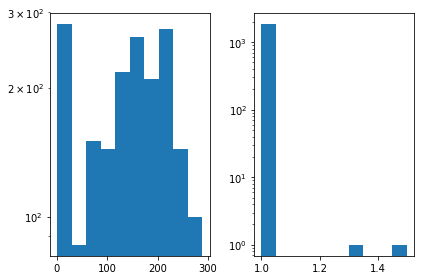

In [10]:
plt.subplot(121)
plt.hist(length, log=True)
plt.subplot(122)
plt.hist(coverage, log=True)
plt.tight_layout()
plt.show()

### I removed all the tips. Noticed that tips overwhelmingly have a length of 1

In [12]:
no_edges = [(u, v, w, cov, length) for u, v, w, cov, length in all_edges if length > 1]
dot = Digraph() #Diagraph(format='png')
[dot.edge(dict_keys[i], dict_keys[v], label=w+' ('+'{:.0f}'.format(length)+', '+'{:.2f}'.format(cov)+')') \
                                             for i, v, w, cov, length in no_edges]
# [dot.edge(dict_keys[i], dict_keys[v]) for i, v, _, _, _ in all_edges]
dot.render('graph_'+str(k)+'mer_notips', view=True)

'graph_55mer_notips.pdf'

### Graph simplification: Introducing tip removal - Remove low coverage and short edges

In [13]:
no_edges = [(u, v, w, cov, length) for u, v, w, cov, length in all_edges if length > 250]
dot = Digraph()
[dot.edge(dict_keys[i], dict_keys[v], label=w+' ('+'{:.0f}'.format(length)+', '+'{:.2f}'.format(cov)+')') \
                                             for i, v, w, cov, length in no_edges]
# [dot.edge(dict_keys[i], dict_keys[v]) for i, v, _, _, _ in all_edges]
dot.render('graph_55'+str(k)+'mer_lowCov', view=True)

'graph_55mer_lowCov.pdf'

### Removing low coverage and short edges results in a disconnected graph so I attempted to recreate a condensed graph after removal. This resulted in a more streamlined graph

## Try a shorter sequence

In [40]:
# Condensed De Brujin Analysis
k = 21
graph = CondensedDeBruijnGraph()
for genome in get_reads(fn): #get_reads(fn): #genomes[2:]: #
    graph.make_graph(genome, k)
graph.make_condensed()

In [42]:
all_edges = [(u, v, w, x[0], x[1]) for u, v, w, x in graph.get_edges()]
all_edges = list(set(all_edges))
all_nodes = graph.get_nodes()
dot = Digraph(format='png') #Diagraph(format='png')
dict_keys = {all_nodes[i]:str(i) for i in range(len(all_nodes)) } 
# [dot.node(dict_keys[i], i) for i in all_nodes]
[dot.edge(dict_keys[i], dict_keys[v], label=w+' ('+'{:.0f}'.format(length)+', '+'{:.2f}'.format(cov)+')') \
                                             for i, v, w, cov, length in all_edges]
# [dot.edge(dict_keys[i], dict_keys[v]) for i, v, _, _, _ in all_edges]
dot.render('graph_forward'+str(k)+'mer', view=True)

'graph_forward21mer.png'